In [1]:
from itertools import zip_longest
from matplotlib.pyplot import figure
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from scipy.sparse import csr_array
from scipy.sparse import find
from pickleshare import PickleShareDB
import math
import networkx as nx
from pyvis.network import Network

df = pd.read_csv('../input/abcnews-date-text.csv')
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#tokenize and sanitize

#tokenize documents into individual words
df['tokenized'] = df.headline_text.str.split(' ')

#remove short documents from corpus
df['length'] = df.tokenized.map(len)
df = df.loc[df.length > 1]

#use random subset of corpus
df=df.sample(frac=0.0001).reset_index()

#flatten all words into single series
ex = df.explode('tokenized')

#remove shorter words
ex = ex.loc[ex.tokenized.str.len() > 2]

#remove stopwords
ex = ex.loc[~ex.tokenized.isin(stopwords_set)]

In [3]:
#ceate dictionary of words

#shuffle for sparse matrix visual
dictionary = ex.tokenized.drop_duplicates().sample(frac=1)

#dataframe with (index/code):word
dictionary = pd.Series(dictionary.tolist(), name='words').to_frame()

#store code:word dictionary for reverse encoding
dictionary_lookup = dictionary.to_dict()['words']

#offset index to prevent clash with zero fill
dictionary['encode'] = dictionary.index + 1

#store word:code dictionary for encoding
dictionary = dictionary.set_index('words').to_dict()['encode']

#use dictionary to encode each word to integer representation
encode = ex.tokenized.map(dictionary.get).to_frame()

bidirectional_bigram  = encode.reset_index().rename(columns={'index':'doc1_1','tokenized':'word1'}).copy()

bidirectional_bigram[['doc1_2','word2']] = bidirectional_bigram.drop(0).reset_index()[['doc1_1','word1']].astype(int)

bidirectional_bigram = bidirectional_bigram.drop(bidirectional_bigram.tail(1).index).astype(int)

#shift that produces bigrams results in invalid bigrams
#number of invalid bigrams is equivalent to number of documents
#remove bigrams not from the same document

bidirectional_bigram = bidirectional_bigram[bidirectional_bigram.doc1_1 == bidirectional_bigram.doc1_2]

bidirectional_bigram['bidirectional_hash'] = bidirectional_bigram.word1.pow(3) + bidirectional_bigram.word2.pow(3)

bidirectional_hash_occurrences = bidirectional_bigram.bidirectional_hash.value_counts().to_dict()

word_occurrences = encode.tokenized.value_counts().to_dict()

num_bidirectional_bigrams = sum(bidirectional_hash_occurrences.values())

num_words = sum(word_occurrences.values())

#convert to symetric coordinates

bidirectional_bigram = pd.concat([bidirectional_bigram, bidirectional_bigram.rename(columns={'word1':'word2','word2':'word1'})],ignore_index=True)

bidirectional_bigram['bidirectional_hash_occurrences'] = bidirectional_bigram.bidirectional_hash.map(bidirectional_hash_occurrences.get)

bidirectional_bigram['word1_occurrences'] = bidirectional_bigram.word1.map(word_occurrences.get)

bidirectional_bigram['word2_occurrences'] = bidirectional_bigram.word2.map(word_occurrences.get)

bidirectional_bigram[['word1','word2']] = bidirectional_bigram[['word1','word2']] - 1


In [7]:
word_graph_dataframe = bidirectional_bigram.rename(columns={'word1':'source','word2':'target','bidirectional_hash_occurrences':'weight'})[['source','target','weight']]

word_graph_dataframe.source = word_graph_dataframe.source.map(dictionary_lookup.get)

word_graph_dataframe.target = word_graph_dataframe.target.map(dictionary_lookup.get)

word_graph_dataframe.weight = (word_graph_dataframe.weight.max() + 1) - word_graph_dataframe.weight

word_graph = nx.from_pandas_edgelist(word_graph_dataframe)

word_net = Network()

word_net.from_nx(word_graph)

word_net.show_buttons()

word_net.save_graph('net.html')



![Web capture_3-12-2023_91144_.jpeg](<attachment:Web capture_3-12-2023_91144_.jpeg>)
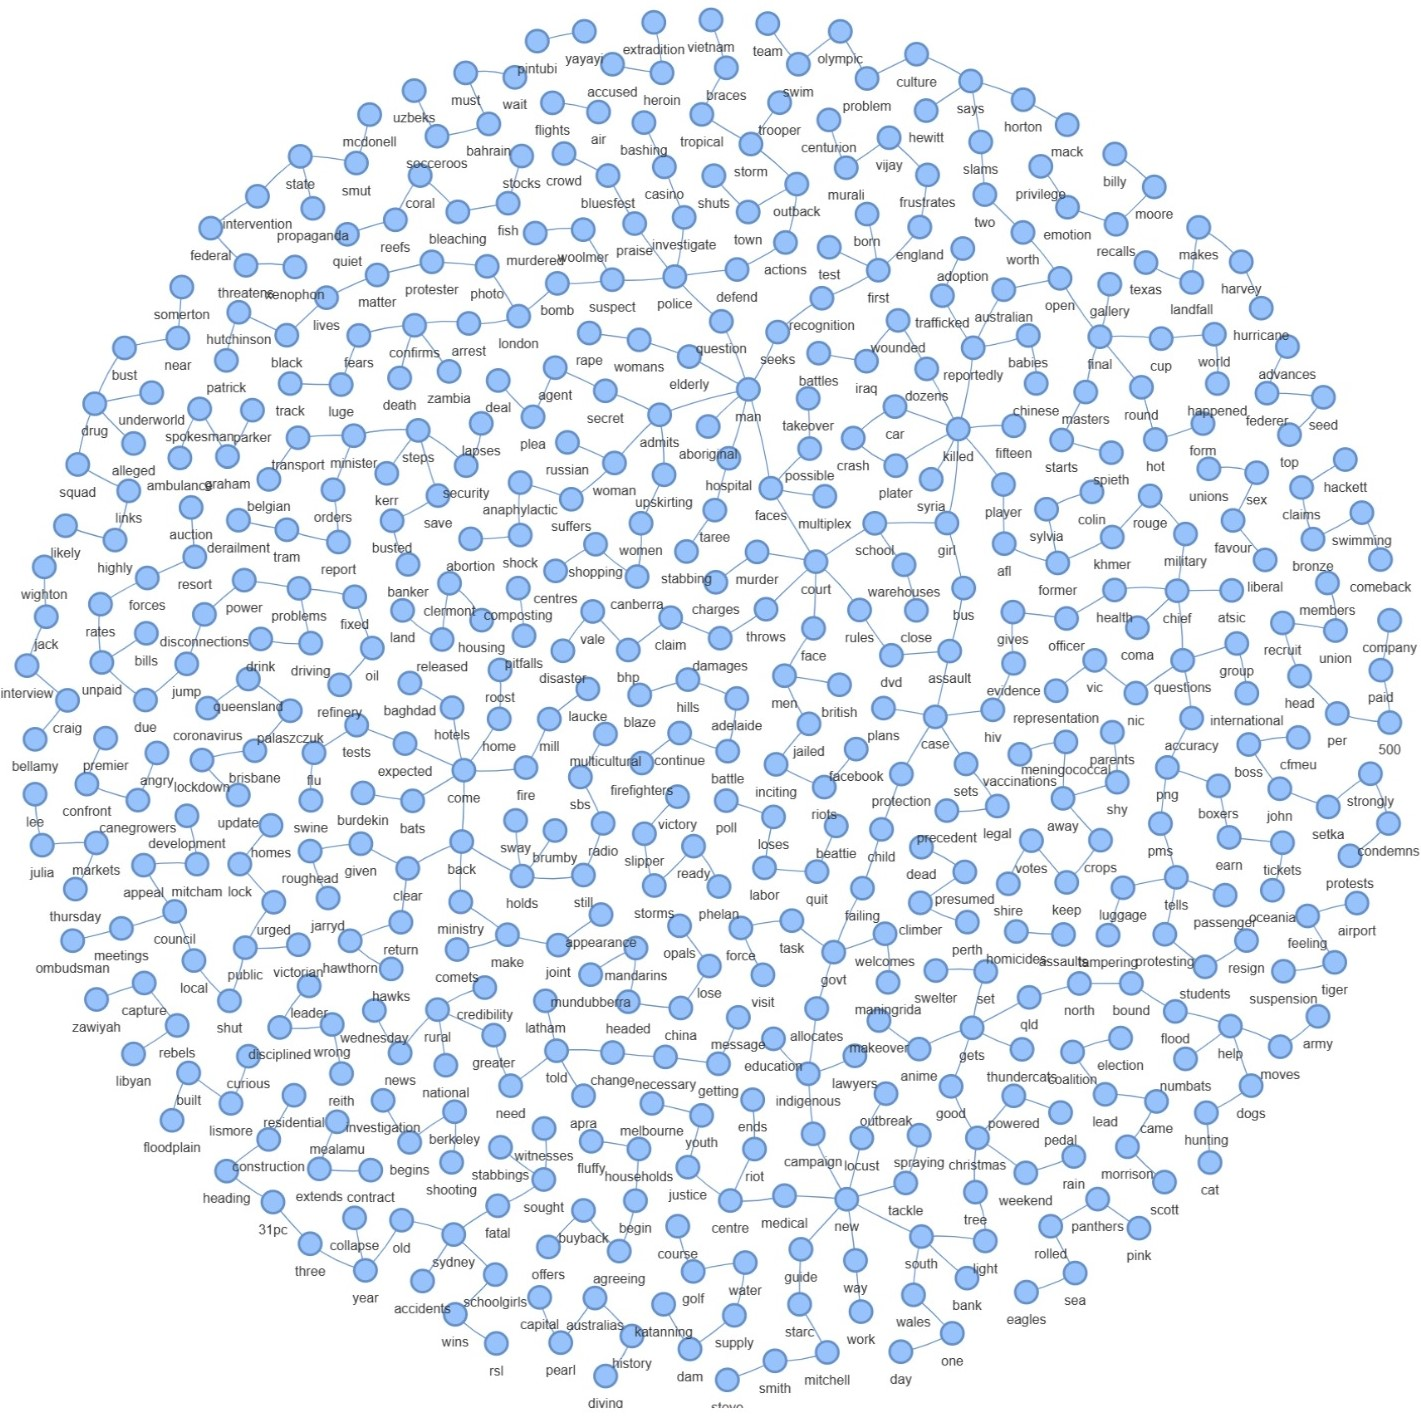